In [27]:
!pip install git+https://github.com/SatelliteApplicationsCatapult/datacube-utilities.git#egg=datacube_utilities

In [29]:
%matplotlib inline
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')

# supress warnings
import warnings
warnings.filterwarnings('ignore')

from datacube_utilities.createindices import NDVI, NDWI, NDBI
from datacube_utilities.dc_mosaic import create_median_mosaic, ls8_unpack_qa
from datacube_utilities.dc_mosaic import create_mosaic, ls8_unpack_qa
import numpy as np
import datacube 
from datetime import datetime
from datacube_utilities.dc_utilities import write_png_from_xr, write_geotiff_from_xr
from datacube_utilities.dc_display_map import display_map

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# NDVI  
<br>  
  
> **NDVI(Normalized Difference Vegetation Index**  
> A derived index that correlates well with the existance of vegetation.  

<br>

$$ NDVI =  \frac{(NIR - RED)}{(NIR + RED)}$$  

<br>

# NDWI  
  
> **NDWI Normalized Difference Water Index**  
> A derived index that correlates well with the existance of water.  
<br>

$$ NDWI =  \frac{GREEN - NIR}{GREEN + NIR}$$  
  
<br>

# NDBI  

> **NDWI Normalized Difference Build-Up Index**  
> A derived index that correlates well with the existance of urbanization.  
<br>

$$ NDBI =  \frac{(SWIR - NIR)}{(SWIR + NIR)}$$  
 
<br>  

# MOSAIC  
  
>**Recent-Pixel-First Mosaic**   
>A cloud free representation of satellite imagery. Works by masking out clouds from imagery, and using the most recent cloud-free pixels in an image.  

![](diagrams/urbanization/flat_mosaic.png)
  
<br>  

In [30]:


def mosaic(dataset):
    # The mask here is based on pixel_qa. It comes bundled in with most Landsat Products.
    clear_xarray  = ls8_unpack_qa(dataset.pixel_qa, "clear")  # Boolean Xarray indicating landcover
    water_xarray  = ls8_unpack_qa(dataset.pixel_qa, "water")  # Boolean Xarray indicating watercover
    
    cloud_free_boolean_mask = np.logical_or(clear_xarray, water_xarray)
    
    return create_mosaic(dataset, clean_mask = cloud_free_boolean_mask)

<br>
  
> **Median Mosaic**  
>  A cloud free representation fo satellite imagery. Works by masking out clouds from imagery, and using the median valued cloud-free pixels in the time series  
  
<br>


![](diagrams/urbanization/median_comp.png)  
  
<br>

In [31]:
def median_mosaic(dataset):
    # The mask here is based on pixel_qa. It comes bundled in with most Landsat Products.
    clear_xarray  = ls8_unpack_qa(dataset.pixel_qa, "clear")  # Boolean Xarray indicating landcover
    water_xarray  = ls8_unpack_qa(dataset.pixel_qa, "water")  # Boolean Xarray indicating watercover
    
    cloud_free_boolean_mask = np.logical_or(clear_xarray, water_xarray)
    
    return create_median_mosaic(dataset, clean_mask = cloud_free_boolean_mask)

<br>  

# Loading Data

> **Data cube object**  
> A datacube object is your interface with data stored on your data cube system.  
<br>  

In [32]:
 
dc = datacube.Datacube(app = '3B_urban')  

<br>

> **Loading a Dataset**  
> Requires latitude-longitude bounds of an area, a time-range, list of desired measurements, platform and product names.

In [33]:
output_projection = "EPSG:3460"
res = (90)
#platform = 'LANDSAT_8'
product = 'ls8_epsg3460_geomedian_annual'
#set baseline start and end of period
#baseline_start_date = '2014'
#baseline_end_date = '2019'

In [34]:
#create resolution
resolution = (-res, res)

In [35]:
from datacube_utilities.createAOI import create_lat_lon
#aoi_wkt = "POLYGON ((178.58022093772888 -17.637723853170563, 178.5840618610382 -17.637723853170563, 178.5840618610382 -17.635096140527168, 178.58022093772888 -17.635096140527168, 178.58022093772888 -17.637723853170563))"
#aoi_wkt = "POLYGON ((177.62557983398438 -17.590848708679893, 177.77372360229492 -17.590848708679893, 177.77372360229492 -17.488875828028657, 177.62557983398438 -17.488875828028657, 177.62557983398438 -17.590848708679893))"
#aoi_wkt = "POLYGON ((177.5727939605713 -18.198369837139474, 177.62858390808105 -18.198369837139474, 177.62858390808105 -18.167709035173743, 177.5727939605713 -18.167709035173743, 177.5727939605713 -18.198369837139474))"
#aoi_wkt = "POLYGON ((178.3652687072754 -18.166893514761473, 178.5051727294922 -18.166893514761473, 178.5051727294922 -18.094460132375914, 178.3652687072754 -18.094460132375914, 178.3652687072754 -18.166893514761473))"
#aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
aoi_wkt = "POLYGON((177.2292273506435 -17.294585993534707,178.706888483456 -17.294585993534707,178.706888483456 -18.434334971348317,177.2292273506435 -18.434334971348317,177.2292273506435 -17.294585993534707))"
lat, lon = create_lat_lon(aoi_wkt)
print("Lat:", lat, "\n"
      "Lon:", lon)

Lat: (-18.434334971348317, -17.294585993534707) 
Lon: (177.2292273506435, 178.706888483456)


In [38]:
new = dc.find_datasets(product='ls8_epsg3460_geomedian_annual')

In [39]:
print(new)

[Dataset <id=4da447b7-e71b-5afb-a2e8-7b6bef1b538c type=ls8_epsg3460_geomedian_annual location=s3://public-eo-data/common_sensing/fiji/landsat_8_geomedian/ls8_geomedian_2013-01-01_2013-12-31_epsg3460_177.0_-19.0_178.0_-18.0_datacube-metadata.yaml>, Dataset <id=80883b0e-c233-5429-ba7f-fc76fd13aa13 type=ls8_epsg3460_geomedian_annual location=s3://public-eo-data/common_sensing/fiji/landsat_8_geomedian/ls8_geomedian_2013-01-01_2013-12-31_epsg3460_177.0_-18.0_178.0_-17.0_datacube-metadata.yaml>, Dataset <id=3adeec3e-3a16-57dc-8ad9-7d00b7e35c53 type=ls8_epsg3460_geomedian_annual location=s3://public-eo-data/common_sensing/fiji/landsat_8_geomedian/ls8_geomedian_2013-01-01_2013-12-31_epsg3460_178.0_-18.0_179.0_-17.0_datacube-metadata.yaml>, Dataset <id=70ccec48-d953-5a21-bfd2-866ebe752a6d type=ls8_epsg3460_geomedian_annual location=s3://public-eo-data/common_sensing/fiji/landsat_8_geomedian/ls8_geomedian_2013-01-01_2013-12-31_epsg3460_178.0_-19.0_179.0_-18.0_datacube-metadata.yaml>, Dataset <id

In [41]:
query = {
    'latitude' : lat,
    'longitude': lon,
    'output_crs': output_projection,  
    'resolution': resolution,
    'product' : product
}

In [42]:
## Loading in a region
start_date = datetime(2013,1,1)
end_date = datetime(2013,12,30)
date_range_base = (start_date,end_date)

#desired_bands = ['red','green','nir','swir2', 'pixel_qa']  # needed by ndvi, ndwi, ndbi and cloud masking
#desired_bands = desired_bands + ['blue'] # blue is needed for a true color visualization purposes

landsat_dataset_base = dc.load(
    #group_by='solar_day',
    time = date_range_base,
    #measurements = desired_bands,
    **query
)

In [43]:
print(landsat_dataset_base)

<xarray.Dataset>
Dimensions:  (time: 1, x: 1747, y: 1410)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-02
  * y        (y) float64 3.967e+06 3.967e+06 3.967e+06 ... 3.841e+06 3.841e+06
  * x        (x) float64 1.838e+06 1.838e+06 1.838e+06 ... 1.995e+06 1.995e+06
Data variables:
    blue     (time, y, x) int16 485 495 494 480 480 475 ... 532 545 569 561 569
    green    (time, y, x) int16 298 302 299 304 307 299 ... 413 420 449 441 448
    red      (time, y, x) int16 242 247 243 251 252 245 ... 355 359 390 379 389
    nir      (time, y, x) int16 242 249 243 251 253 247 ... 350 358 390 378 388
    swir1    (time, y, x) int16 222 225 222 231 234 231 ... 336 349 388 372 386
    swir2    (time, y, x) int16 191 194 190 200 202 199 ... 280 290 322 306 318
Attributes:
    crs:      EPSG:3460


In [44]:
display_map(latitude = lat, longitude = lon)  

<br>  

# Displaying Data  
<br>  

>**A cloud free composite**  
Clouds get in the way of understanding the area. Cloud free composites draw from a history of acquisitions to generate a cloud free representation of your area  

<br>  

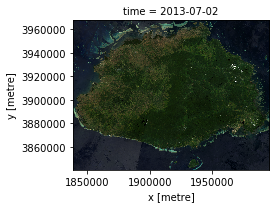

In [45]:
landsat_dataset_base[['red','green','blue']].to_array().plot.imshow(
    x=landsat_dataset_base.crs.dimensions[1],
    y=landsat_dataset_base.crs.dimensions[0],
    col='time',
    #figsize=(20, 20),
    vmin=0,
    vmax=3000,
    col_wrap=4,
    #add_colorbar=False
)

In [46]:
print(landsat_dataset_base)

<xarray.Dataset>
Dimensions:  (time: 1, x: 1747, y: 1410)
Coordinates:
  * time     (time) datetime64[ns] 2013-07-02
  * y        (y) float64 3.967e+06 3.967e+06 3.967e+06 ... 3.841e+06 3.841e+06
  * x        (x) float64 1.838e+06 1.838e+06 1.838e+06 ... 1.995e+06 1.995e+06
Data variables:
    blue     (time, y, x) int16 485 495 494 480 480 475 ... 532 545 569 561 569
    green    (time, y, x) int16 298 302 299 304 307 299 ... 413 420 449 441 448
    red      (time, y, x) int16 242 247 243 251 252 245 ... 355 359 390 379 389
    nir      (time, y, x) int16 242 249 243 251 253 247 ... 350 358 390 378 388
    swir1    (time, y, x) int16 222 225 222 231 234 231 ... 336 349 388 372 386
    swir2    (time, y, x) int16 191 194 190 200 202 199 ... 280 290 322 306 318
Attributes:
    crs:      EPSG:3460


In [26]:
landsat_mosaic_base = landsat_dataset_base.rename({"x":"latitude", "y":"longitude"})
write_geotiff_from_xr('landsat_dataset_base.tiff', landsat_mosaic_base, ["red", "green", "blue"], crs=output_projection)

ValueError: Source shape (1, 1, 1410, 1747) is inconsistent with given indexes 1

In [16]:
landsat_mosaic_base = landsat_dataset_base


In [17]:
#del landsat_dataset_base

<br>  
> **Saving your data**  
> A .tiff or png is a great way to represent true color mosaics. The image below is a saved .png representation of of a landsat mosaic.  

In [18]:
landsat_mosaic_base = landsat_mosaic_base.rename({"x":"latitude", "y":"longitude"})
cloud_Free_base = write_png_from_xr('cloud_free_mosaic_base.png', landsat_mosaic_base, ["red", "green", "blue"], scale = [(0,2000),(0,2000),(0,2000)], crs="EPSG:32760")
write_geotiff_from_xr('cloud_free_mosaic_base.tiff', landsat_mosaic_base, ["red", "green", "blue"], crs=output_projection)


ValueError: Source shape (1, 1, 1410, 1747) is inconsistent with given indexes 1

<br>  

![](diagrams/urbanization/cloud_free_mosaic.png)  
  
<br>  

# Urbanization Analysis  

> **NDWI, NDVI, NDBI**  
You will very rarely have urban classification and water classifications apply to the same pixel. For urban analysis, it may make sense to compute not just urban classes, but classes that are unlikely to co-occur with urbanization. 
  
<br>

In [ ]:
ndbi_base = NDBI(landsat_mosaic_base)  # Urbanization
ndvi_base = NDVI(landsat_mosaic_base)  # Dense Vegetation
ndwi_base = NDWI(landsat_mosaic_base)  # High Concentrations of Water

>**Plot Values**  
> xarray data-arrays have built in plotting functions you can use to validate trends or differences in your data.  
<br>
  

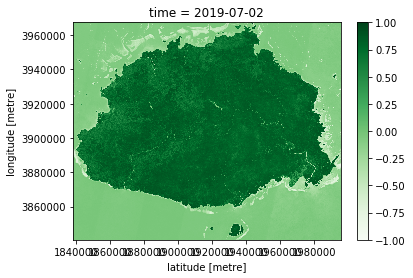

In [20]:
(ndvi_base).plot(cmap = "Greens", vmin = -1, vmax = 1)

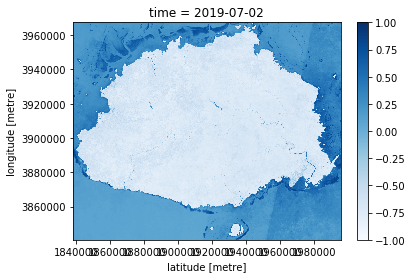

In [21]:
(ndwi_base).plot(cmap = "Blues", vmin = -1, vmax = 1)

In [ ]:
(ndbi_base).plot(cmap = "Reds", vmin = -1, vmax = 0)

> **Convert To a Dataset**  
It's good practice to accurately name your datasets and data-arrays. If you'd like to merge data-arrays into a larger datasets, you should convert data-arrays to datasets

In [ ]:
ds_ndvi_base = ndvi_base.to_dataset(name = "NDVI")
ds_ndwi_base = ndwi_base.to_dataset(name=  "NDWI")
ds_ndbi_base = ndbi_base.to_dataset(name = "NDBI")

> **Merge into one large Dataset**  
> If your data-arrays share the same set of coordinates, or if you feel that you'll be using these values together in the future,  you should consider merging them into a dataset

In [ ]:
urbanization_dataset_base = ds_ndvi_base.merge(ds_ndwi_base).merge(ds_ndbi_base)

<br>  
<br>  

>**Building a False Color Composite**  
> If you have three lowly correlated measurements, place each measurement on its own Red, Green, Blue channel and visualize it. 

In [ ]:
write_png_from_xr('false_color_base.png', urbanization_dataset_base, ["NDBI", "NDVI", "NDWI"], scale = [(-1,1),(0,1),(0,1)])
write_geotiff_from_xr('false_color_base.tiff', urbanization_dataset_base, ["NDBI", "NDVI", "NDWI"], crs=output_projection)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_base = mpimg.imread("false_color_base.png")
plt.imshow(image_base)
plt.show()

In [ ]:
#image_base = mpimg.imread("false_color_analy.png")
#plt.imshow(image_base)
#plt.show()

![](diagrams/urbanization/false_color.png)

>**Analyze The False Color Image**  

> Values that adhere strongly to individual classes adhere to their own color channel. In this example, NDVI adheres to green, NDWI adheres to blue, and NDBI seems to adhere to red  

> **Validate urbanization using other imagery**  
> Double check results using high-resolution imagery.  Compare to the false color mosaic
<br>

In [ ]:
display_map(latitude = lat ,longitude = lon)  

## set thresholds for ndvi, ndwi and ndbi

In [ ]:
#ndwi
ndwi_min = -1
ndwi_max = -0.1
#ndvi
ndvi_min = -1
ndvi_max = 0.5
#ndbi
#ndbi_min = -0.9
#ndbi_max = 0

ndbi_min = -0.25
ndbi_max = 0.3

In [ ]:
ndwi_mask_base = np.logical_and(ndwi_base > ndwi_min, ndwi_base < ndwi_max) 
ndvi_mask_base = np.logical_and(ndvi_base > ndvi_min, ndvi_base < ndvi_max)
ndbi_mask_base = np.logical_and(ndbi_base > ndbi_min, ndbi_base < ndbi_max)

In [ ]:
ndwi_mask_base.plot(cmap = "Greens")

In [ ]:
ndvi_mask_base.plot(cmap = "Greens")

In [ ]:
ndbi_mask_base.plot(cmap = "Reds")

In [ ]:
#create a mask here 

In [ ]:
from datacube.storage import masking
mask_ndwi_base = masking.mask_invalid_data(ndwi_mask_base)
mask_ndvi_base = masking.mask_invalid_data(ndvi_mask_base)
mask_ndbi_base = masking.mask_invalid_data(ndbi_mask_base)

In [ ]:
#mask_ndwi_analy = masking.mask_invalid_data(ndwi_mask_analy)
#mask_ndvi_analy = masking.mask_invalid_data(ndvi_mask_analy)
#mask_ndbi_analy = masking.mask_invalid_data(ndbi_mask_analy)

In [ ]:
ndbi_test_base = ndbi_base.where(mask_ndwi_base)
ndbi_test_base = ndbi_test_base.where(mask_ndvi_base)
ndbi_test_base = ndbi_test_base.where(mask_ndbi_base)

In [ ]:
#ndbi_test_analy = ndbi_analy.where(mask_ndwi_analy)
#ndbi_test_analy = ndbi_test_analy.where(mask_ndvi_analy)
#ndbi_test_analy = ndbi_test_analy.where(mask_ndbi_analy)

In [ ]:
ndbi_test_base.plot(cmap = "RdYlGn")

In [ ]:
write_geotiff_from_xr('false_color_base.tiff', ndbi_test_base, crs= output_projection)

In [ ]:
#####experimenting with ndvi - ndbi
#test2 = ndvi_base - ndbi_base
test2 = np.subtract(ndbi_base, ndvi_base)
#RdYlGn.set_bad('black',1.)
test2.plot(cmap = "RdYlGn")
test3 = test2.where(mask_ndwi_base)
test3 = test3.where(mask_ndvi_base)

In [ ]:
test3.plot(cmap = "RdYlGn")

In [ ]:
cloud_free_image = mpimg.imread("cloud_free_mosaic.png")
plt.imshow(cloud_free_image)
plt.show()

In [ ]:
#test = np.subtract(ndbi_test_analy, ndbi_test_base)

In [ ]:
test.plot()

In [ ]:
def aspect_ratio_helper(ds, fixed_width = 12):
        y,x = ds.values.shape
        width = fixed_width
        height = y * (fixed_width / x)
        return (width, height)

In [ ]:
from matplotlib.cm import RdYlGn, Greens
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

In [ ]:
plt.figure(figsize = aspect_ratio_helper(test)) 
test.plot(cmap = RdYlGn)

In [ ]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>

# Select an Anomaly Threshold Range to filter the results from the previous image
# Be sure to put the smallest value in the "minimum_change" location (be careful of negative values)

# Losses are typically in these ranges for deforestation
# NDVI: -0.2 to -0.7
# EVI: -0.5 to -1.75
# Fractional Cover PV: -20 to -70

minimum_change = -0.2
maximum_change = -1

In [ ]:
# Create a threshold plot using the MIN and MAX range defined above

from matplotlib.ticker import FuncFormatter

def threshold_plot(da, min_threshold, max_threshold, mask = None, width = 10, *args, **kwargs): 
    color_in    = np.array([255,0,0])
    color_out   = np.array([0,0,0])
    color_cloud = np.array([255,255,255])
    
    array = np.zeros((*da.values.shape, 3)).astype(np.int16)
    
    inside  = np.logical_and(da.values > min_threshold, da.values < max_threshold)
    outside = np.invert(inside)
    masked  = np.zeros(da.values.shape).astype(bool) if mask is None else mask
    
    array[inside] =  color_in
    array[outside] = color_out
    array[masked] =  color_cloud

    def figure_ratio(ds, fixed_width = 10):
        width = fixed_width
        height = len(ds.latitude) * (fixed_width / len(ds.longitude))
        return (width, height)


    fig, ax = plt.subplots(figsize = figure_ratio(da,fixed_width = width))
    
    lat_formatter = FuncFormatter(lambda y_val, tick_pos: "{0:.3f}".format(da.latitude.values[tick_pos] ))
    lon_formatter = FuncFormatter(lambda x_val, tick_pos: "{0:.3f}".format(da.longitude.values[tick_pos]))

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    plt.title("Threshold: {} < x < {}".format(min_threshold, max_threshold))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.imshow(array, *args, **kwargs)
    plt.show()

In [ ]:
no_data_mask = (np.isnan(ndbi_test_base.values)) 

In [ ]:
threshold_plot(test, minimum_change, maximum_change, mask = no_data_mask)

In [ ]:
min_change = 0.3
max_change = 1
threshold_plot(test, min_change, max_change, mask = no_data_mask )